In [1]:
import numpy as np
import torch
from torch import nn, distributions
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [2]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=ToTensor())
mnist_test  = datasets.MNIST("../data", train=False,download=True, transform=ToTensor())
traindataloader = DataLoader(mnist_train, shuffle=True, batch_size=60000)
testdataloader  = DataLoader(mnist_test , shuffle=True, batch_size=10000)
X_train, y_train = next(iter(traindataloader))
X_test , y_test  = next(iter(testdataloader))

X_train = X_train.reshape(60000, -1)
X_test = X_test.reshape(10000, -1)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# sepeate train data into (1) initial, (2) pool
initial_idx = np.array([],dtype=np.int)
for i in range(10):
    idx = np.random.choice(np.where(y_train==i)[0], size=2, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [4]:
# BALD Acquisition function
def bald(model_A, model_S1, model_S2, X, n_instances, T = 100):
  
    random_subset = np.random.choice(range(len(X)), size=len(X), replace=False)
    with torch.no_grad():
        x = X[random_subset].to(device)
        outputs = np.stack([torch.exp(model_A(x)).detach().cpu().numpy() for t in range(T)])

    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0) 
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]

    score_A = acquisition[query_idx]
    
    #---------------- score for successors:
    with torch.no_grad():
        output_S1 = np.stack([torch.exp(model_S1(X[query_idx].to(device))).detach().cpu().numpy() for t in range(T)])
        output_S2 = np.stack([torch.exp(model_S2(X[query_idx].to(device))).detach().cpu().numpy() for t in range(T)])

    pc = output_S1.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S1 * np.log(output_S1 + 1e-10), axis=-1), axis=0) 
    score_S1 = H - E_H

    pc = output_S2.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S2 * np.log(output_S2 + 1e-10), axis=-1), axis=0) 
    score_S2 = H - E_H

    return (query_idx, score_A, score_S1, score_S2) 

In [14]:
def active_learning_procedure(X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              n_queries=30, # 
                              n_instances=1000):


    x_train_sample = X_initial
    y_train_sample = y_initial

    train_loader = DataLoader(list(zip(x_train_sample,  y_train_sample)), 
                          shuffle=False, batch_size = len(y_train_sample))
    test_loader = DataLoader(list(zip(X_test,  y_test)), 
                          shuffle=False, batch_size = 10000)
    #----- Model A --------------------------
    A = Model1(784, 10, n_batches=1).to(device)
    optim0 = torch.optim.Adam(A.parameters(), lr=0.02)
    _, train_acc, _, test_acc = train(A, optim0, 150, train_loader, test_loader, verbose = False)
    acquisition_hist  = [test_acc[-1]]


    #----- Model S --------------------------
    S1 = Model2(784, 392, 10, n_batches=1).to(device)
    optim1 = torch.optim.Adam(S1.parameters(), lr=0.015)
    _, train_acc, _, test_acc = train(S1, optim1, 250, train_loader, test_loader, verbose = False)
    successor1_hist = [test_acc[-1]]

    S2 = Model3(784, [392, 196], 10, n_batches=1).to(device)
    optim2 = torch.optim.Adam(S2.parameters(), lr=0.013)
    _, train_acc, _, test_acc = train(S2, optim2, 550, train_loader, test_loader, verbose = False)
    successor2_hist = [test_acc[-1]]

    scores = list()

    for index in range(n_queries):
        # for incomplete sampling:
        #query_idx = np.concatenate([bald(A, X_pool) for n in range(n_instances)])

        # for complete set BALD:
        query_idx, score_A, score_S1, score_S2 = bald(A, S1, S2, X_pool, n_instances)
        scores.append(np.vstack((score_A, score_S1, score_S2)))

        # for iid sampling
        #query_idx = np.random.randint(0, len(y_pool), n_instances)

        x_train_sample = torch.vstack((x_train_sample, X_pool[query_idx]))
        y_train_sample = torch.cat((y_train_sample,y_pool[query_idx]))

        train_loader = DataLoader(list(zip(x_train_sample,  y_train_sample)), 
                          shuffle=False, batch_size = len(y_train_sample))
        
        # model A:
        A = Model1(784, 10, n_batches=1).to(device)
        optim0 = torch.optim.Adam(A.parameters(), lr=0.02)
        _, train_acc, _, test_acca = train(A, optim0, 150, train_loader, test_loader, verbose = False)
        acquisition_hist.append(test_acca[-1])

        # model S:
        S1 = Model2(784, 392, 10, n_batches=1).to(device)
        optim1 = torch.optim.Adam(S1.parameters(), lr=0.015)
        _, train_acc, _, test_acc1 = train(S1, optim1, 250, train_loader, test_loader, verbose = False)
        successor1_hist.append(test_acc1[-1])

        S2 = Model3(784, [392, 196], 10, n_batches=1).to(device)
        optim2 = torch.optim.Adam(S2.parameters(), lr=0.013)
        _, train_acc, _, test_acc2  = train(S2, optim2, 550, train_loader, test_loader, verbose = False)
        successor2_hist.append(test_acc2[-1])

        
        # delete queried data from pool:
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        print('Query {n}: {acc:0.4f}(Model A)    |     {acc_s1:0.4f}(Model S1) - {acc_s2:0.4f}(Model S2) '.format(n=index + 1, acc=test_acca[-1], acc_s1 = test_acc1[-1], acc_s2 = test_acc2[-1]))     
        
    return(acquisition_hist, successor1_hist, successor2_hist, scores)

In [6]:
class LinearVariational(nn.Module):
    def __init__(self, in_features, out_features, loss_accumulator, n_batches, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.include_bias = bias        
        self.loss_accumulator = loss_accumulator
        self.n_batches = n_batches
        
        if getattr(loss_accumulator, 'accumulated_kl_div', None) is None:
            loss_accumulator.accumulated_kl_div = 0

        self.w_mu = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=0, std=0.001)
        )
        # proxy for variance
        # log(1 + exp(ρ))◦ eps
        self.w_p = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=-2.5, std=0.001)
        )
        if self.include_bias:
            self.b_mu = nn.Parameter(
                torch.zeros(out_features)
            )
            self.b_p = nn.Parameter(
                torch.zeros(out_features)
            )
        
    def reparameterize(self, mu, p):
        sigma = torch.log(1 + torch.exp(p)) 
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)
    
    def kl_divergence(self, z, mu_theta, p_theta, prior_sd=1):
        log_prior = distributions.Normal(0, prior_sd).log_prob(z) 
        log_p_q = distributions.Normal(mu_theta, torch.log(1 + torch.exp(p_theta))).log_prob(z) 
        return (log_p_q - log_prior).mean() / self.n_batches

    def forward(self, x):
        w = self.reparameterize(self.w_mu, self.w_p)
        
        if self.include_bias:
            b = self.reparameterize(self.b_mu, self.b_p)
        else:
            b = 0
            
        z = x @ w + b
        
        self.loss_accumulator.accumulated_kl_div += self.kl_divergence(w, 
                                                             self.w_mu,
                                                             self.w_p, 
                                                             )
        if self.include_bias:
            self.loss_accumulator.accumulated_kl_div += self.kl_divergence(b, 
                                                                 self.b_mu, 
                                                                 self.b_p,
                                                                 )
        return z


@dataclass
class KL:
    accumulated_kl_div = 0

def det_loss(y, y_pred, model):
    batch_size = y.shape[0]
    reconstruction_error = F.nll_loss(y_pred, y,reduction="mean")
    kl = model.accumulated_kl_div
    model.reset_kl_div()
    return reconstruction_error + kl



In [7]:
class Model1(nn.Module):
    def __init__(self, in_size, out_size, n_batches):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, out_size, self.kl_loss, n_batches),
            nn.LogSoftmax(dim = 1)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
       # x = x.view(-1, 784)
        return self.layers(x)

class Model2(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batches):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size, self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size, out_size, self.kl_loss, n_batches),
            nn.LogSoftmax(dim = 1)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
       # x = x.view(-1, 784)
        return self.layers(x)

class Model3(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, n_batches):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size[0], self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size[0], hidden_size[1], self.kl_loss, n_batches),
            nn.ReLU(),
            LinearVariational(hidden_size[1], out_size, self.kl_loss, n_batches),
            nn.LogSoftmax(dim = 1)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
       # x = x.view(-1, 784)
        return self.layers(x)

In [8]:
# Train
def train(model, optimizer, num_epoch, train_loader, valid_loader, verbose = False):
  train_ls = list()
  train_acc = list()
  valid_ls = list()
  valid_acc = list()

  # early_ls = list()

  for epoch in range(num_epoch):
      ls = 0
      num_correct = 0
      data_num = 0

      model.train()
      for bs_num, (x, y) in enumerate(train_loader):

          x = x.to(device)
          y = y.to(device)
          
          # forward:
          y_pred = model(x)
          loss = det_loss(y, y_pred, m)
          ls += loss.item()
          
          # backward:
          optimizer.zero_grad() # remove grad from forward prop
          loss.backward()
          
          # update gradient:
          optimizer.step()
          
          # accuracy:
          _, pred = torch.max(y_pred,1)
          num_correct += (pred == y).sum().item()

          data_num += len(y)

      acc = num_correct/data_num
      val_ls, val_acc = eval_acc(model, valid_loader)
      if verbose:
        print(epoch+1)
        print(f'\tLoss: {ls:.4f}(train)\t|\tAcc: {acc * 100:.1f}%(train)')
        print(f'\tLoss: {val_ls:.4f}(valid)\t|\tAcc: {val_acc * 100:.1f}%(valid)')
      train_ls.append(ls)
      train_acc.append(acc)
      valid_ls.append(val_ls)
      valid_acc.append(val_acc)

      # access early stopping:
      #if (epoch <= (patient+1)):
      #  early_ls.append(val_ls)
      #else:
      #  early_ls.pop(0)
      #  early_ls.append(val_ls)
      #  cum_diff = [x - early_ls[i - 1] for i, x in enumerate(early_ls)][1:]
      #  ear_stop = all(i >= 0 for i in cum_diff)
      #  if (ear_stop):
      #    if (verbose):
      #      print('Early stopping: consecutive {} epochs without improvement.'.format(patient))
      #      break

  return(train_ls, train_acc, valid_ls, valid_acc)


def eval_acc(model, loader):
  num_correct = 0
  ls = 0
  data_num = 0
  all_pred = list()
  label = list()

  model.eval()
  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device)

      y_pred = model(x)
      loss = det_loss(y, y_pred, m)
      ls += loss.item()

      _, pred = torch.max(y_pred,1)
      num_correct += (pred == y).sum().item()
      data_num += len(y)

    model.train()
    return(ls, num_correct/data_num)



In [9]:
train_loader = DataLoader(list(zip(X_train,  y_train)), 
                      shuffle=False, batch_size = 60000)
test_loader = DataLoader(list(zip(X_test,  y_test)), 
                      shuffle=False, batch_size = 10000)

In [ ]:
m = Model3(784, [392, 196], 10, n_batches=1).to(device)
optim = torch.optim.Adam(m.parameters(), lr=0.013)
train_ls, train_acc, valid_ls, valid_acc = train(m, optim, 550, train_loader, test_loader, verbose = True)

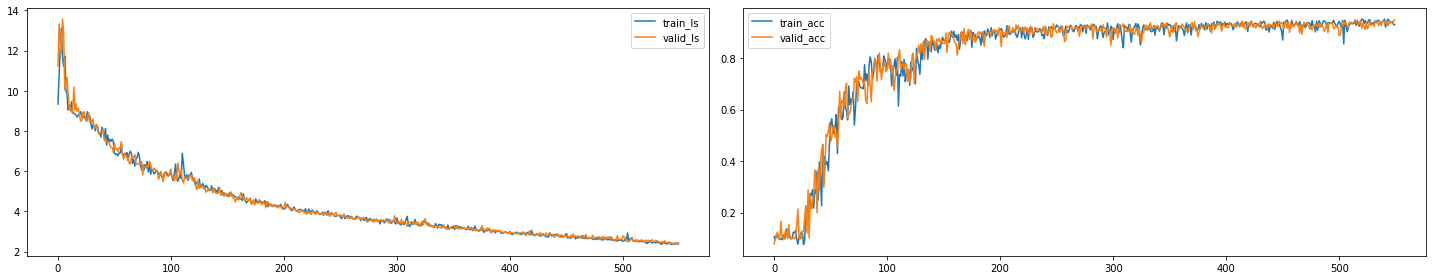

In [12]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize = (20,4))

epoch = 549
axs[0].plot(range(epoch+1), train_ls, label = 'train_ls')
axs[0].plot(range(epoch+1), valid_ls, label = 'valid_ls')
axs[0].legend()
axs[1].plot(range(epoch+1), train_acc, label = 'train_acc')
axs[1].plot(range(epoch+1), valid_acc, label = 'valid_acc')
axs[1].legend()


In [11]:
query_idx, score_A, score_S1, score_S2 = bald(m, m, m, X_pool, 1000, T = 100)

In [16]:
np.vstack((score_A, score_S1, score_S2)).shape

(3, 1000)

In [ ]:
with torch.no_grad():
    x = X_test[random_subset].to(device)

    y_pred = m(x)
   
        outputs = np.stack([torch.exp(m(x)).detach().cpu().numpy() for t in range(T)])

array([707])

In [ ]:
x = X_test[random_subset].to(device)
m(x)

tensor([[-12.8073, -20.3136, -10.1450, -12.4391,  -9.1797, -16.8512, -13.8193,
          -0.5437,  -8.1444,  -0.8699],
        [ -3.7020, -22.7614, -20.3608, -10.2424,  -2.1479,  -7.2331, -16.8376,
          -0.1757, -13.8170,  -3.9654]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)

In [ ]:
np.stack([torch.exp(m(x)).detach().cpu().numpy() for t in range(2)]).mean(axis = 0)

array([[7.05653219e-05, 2.55348425e-07, 1.07638582e-04, 7.95450433e-06,
        2.12055020e-04, 2.53280268e-06, 3.92722029e-07, 1.30245179e-01,
        1.73626657e-04, 8.69179845e-01],
       [3.82382125e-01, 4.72449944e-12, 4.21593462e-08, 4.44664853e-03,
        3.81617874e-01, 2.61833854e-02, 6.79468542e-07, 1.23382965e-02,
        2.43220302e-06, 1.93028569e-01]], dtype=float32)

In [ ]:
rand_idx = np.concatenate([bald(m, X_pool) for n in range(10)])

In [ ]:
bald(m, X_pool)

array([32554])

In [ ]:
acquisition_hist, successor1_hist, successor2_hist, scores = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial)

Query 1: 0.5411(Model A)    |     0.4903(Model S1) - 0.5022(Model S2) 
Query 2: 0.5899(Model A)    |     0.5737(Model S1) - 0.6170(Model S2) 


In [ ]:
query_idx = np.concatenate([bald(m, X_pool) for n in range(10)])


In [18]:
X_pool[query_idx].shape

torch.Size([1000, 784])

In [ ]:
x_train_sample = X_initial
x_train_sample = torch.vstack((x_train_sample, X_pool[query_idx]))

In [ ]:
x_train_sample.shape

torch.Size([20, 784])

In [ ]:
y_train_sample = y_initial
torch.cat((y_train_sample,y_pool[query_idx]))


tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 6, 6, 2, 5,
        6, 7, 4, 6, 2, 6])

In [ ]:
y_pool[query_idx]

tensor([6, 6, 2, 5, 6, 7, 4, 6, 2, 6])

In [ ]:
y_train_sample

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9])